---
layout: page
title: Tesla Ark Invest TSLA Price Targets
---

In [1]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import StandardChart, LogChart, PercentileChart

## Dear Elon: An Open Letter

On 7 August 2018 Musks' infamous "funding secured" tweet considered a potential buy back at $420 per share. Given TSLA was trading around $240 a share, that may have seemed a reasonably strong 2x return on investment. 

Two weeks later on 22 August 2018, Ark Invest CEO Cathy Woods published a blog titled "[Dear Elon: An Open Letter Against Taking Tesla Private](https://ark-invest.com/articles/analyst-research/tesla-private/)" in which Cathy explained the enormous disruptive growth potential over a long term (five year) time horizon.

Ark Invest's research and modeling forecast a bear, base and bull case scenario that suggested a 2023 price target somewhere between $700 and $4,000; significantly higher than the suggested $420 offer price, and subsequently a huge financial loss to investors should Tesla become a private company before these forecast gains were realized.

Thankfully for all investors, Tesla remained a public company and ARK Invest continue to publish research on disruptive innovation. The actual 1 July 2023 price of $175 before split adjustments would have been $2,625, close to Ark Invest's five year target base price.

Ark Invest have since updated and published four year price targets every year, usually around mid-April, although the forecast published on 12 June 2024 included a five year price target for 2029.

In [2]:
df_tsla = pd.DataFrame()
# Restore dataframe from previous notebook
%store -r df_tsla

In [3]:
""" Load data """
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
df_targets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
df_targets = df_targets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
df_targets.columns = df_targets.columns.str.strip()
# Remove leading/trailing white spaces from data
df_targets = df_targets.map(lambda x: x.strip() if isinstance(x, str) else x)

In [4]:
""" Data Transformation """
df_targets['Date'] = pd.to_datetime(df_targets['TargetDate'],dayfirst=True)
df_targets['ForecastDate'] = pd.to_datetime(df_targets['ForecastDate'],dayfirst=True)
df_targets.set_index('Date', inplace=True)
df_targets = df_targets.sort_index()

In [5]:
""" Adjust price targets for stock splits """
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

df_targets_pre_split = df_targets.copy()
# 5-for-1 price split
df_targets = df_targets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
df_targets = df_targets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [6]:
custom_colors = {}
custom_colors['tsla']='#3f77e4'
custom_colors['ARKInvest']={
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
custom_colors['SMR']={
    'base': 'limegreen',
}
custom_colors['InvestA']={
    'base': 'yellowgreen',
}
custom_colors['RandyKirk']={
    'bear': 'forestgreen',
}
custom_colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]

## Impossible Exponential Growth

In mid 2018 when TSLA was trading around $240 a share, the Ark Invest 2023 price targets of somewhere between $700 and $4,000 seemed ridiculous (pre-split prices). At the time many 'expert' financial analysts claimed this was simply not possible.

The ongoing Ark Invest four year price targets may still seem ridiculous to many 'expert' finanical analysts, especially when plot on a standard chart with the TSLA price targets split adjusted to current prices:

In [7]:
def plot_rolling_forecast(plt, df_targets, source):
    df_source = df_targets[df_targets['Source'] == source]
                
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = df_source.drop_duplicates(subset=['ForecastDate'])
    if len(rolling_forecast) > 1:
        #if group['Bear'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=source+' Bear', color=custom_colors[source]['bear'])
        #if group['Base'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=source, color=custom_colors[source]['base'])
        #if group['Bull'].notna().sum() > 1:
        plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=source+' Bull', color=custom_colors[source]['bull'])   

    right_limit = rolling_forecast.last_valid_index() + pd.offsets.YearBegin(1)   
    if right_limit.timestamp() > mdates.num2date(plt.xlim()[1]).timestamp():  
        plt.xlim(right=right_limit)    
    return plt

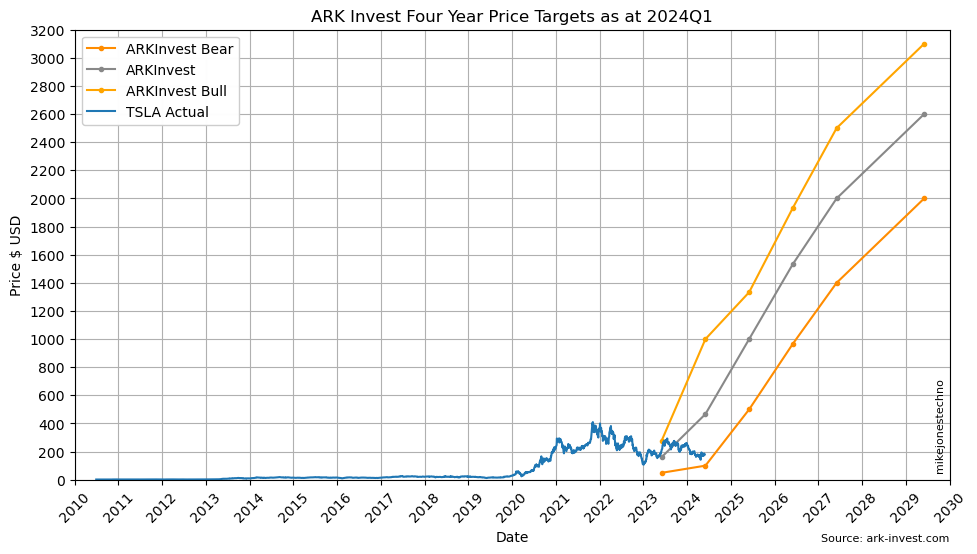

In [14]:
""" Extend simple chart with ARK price targets """
sx_symbol = 'TSLA'
data_column = 'Adj Close'
last_index = df_tsla[data_column].last_valid_index() # pandas timestamp

chart_params = {
    'chart_title': 'ARK Invest Four Year Price Targets as at ' + str(pd.Period(str(last_index), freq='Q') -1), 
    'chart_source': 'Source: ark-invest.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 200,
    'x_label': 'Date', 
    'x_ticks': 1,
    'top_limit': 3200,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt_std, colors = standard_chart.base_chart(df_tsla)

plt_std = plot_rolling_forecast(plt_std, df_targets, 'ARKInvest')   
plt_std.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

legend = plt_std.legend(loc='best')
legend.get_frame().set_alpha(0.98)

plt_std.show()

Exponential growth usually requires a long time horizon. 

The S&P 500 (SPX) has a consistent median annual growth rate of 12% and the exponential curve is clearly visible over a 50 year time horizon. Plotting the same [SPX prices on a logarithmic y-axis scale](spx.html) produces a straight line up and to the right. 

<a href="spx.html" style="text-align: center; display: block"><img src="images/spx_5_0.png" width="400"/> <img src="images/spx_7_0.png" width="400"/></a>

Similarly, plotting the [TSLA prices on a logarithmic y-axis scale](tsla.html) produces a step line up and to the right. 

## Logarithmic Perspective

When evaluating long term exponential growth, a logarithmic scale makes it easier to visualize the long term trend.

On a logarithmic y-axis scale the ARK invest four year forecasts appear to be a refined continuation of the existing long term trend.

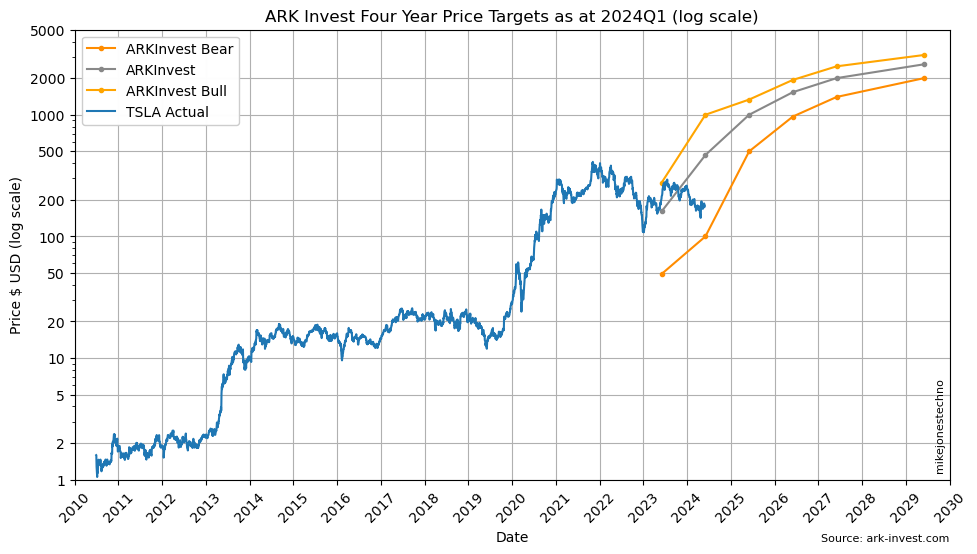

In [9]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = log_chart_params['chart_title'] + ' (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

log_chart = LogChart(**log_chart_params)
plt_log, colors = log_chart.base_chart(df_tsla)

plt_log = plot_rolling_forecast(plt_log, df_targets, 'ARKInvest')
plt_log.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

legend = plt_log.legend(loc='best')
legend.get_frame().set_alpha(0.98)
plt_log.show()

### Disruptive Fundamentals

Beware of the short-term noise of quarterly financials, day-trader youtubers, and 'expert' financial analysts; long term investors should research disruptive technology themselves and study the underlying fundamental business proposition.

In 2022 Ark Invest clarified that their four year model for the 2026 price targets was 'methodologically conservative'. 

ARK Invest provided an extended eight year price target trajectory to 2030 with a note that forecasting for an eight year time horizon has an increased risk of potential errors. For example "vehicle form factors could change significantly relative to those in our current model, and some of the business opportunities we have not modeled, such as AI-as-a-service, could be more meaningful contributors to Tesla’s financials."

In [10]:
def plot_forecast(plt, df_targets, source, label = ''):
    df_source = df_targets[df_targets['Source'] == source]
                
    # Plot forecast trajectory eg multi year forecasts that were predicted on same date.
    trajectory_forecast = df_source.groupby('ForecastDate')
    for name, group in trajectory_forecast:
        if len(group) > 1:
            if group['Bear'].notna().sum() > 1 and 'bear' in custom_colors[source]:
                plt.plot(group.index, group['Bear'], marker='.', linestyle='dashed', label=source+' Bear', alpha=0.5, color=custom_colors[source]['bear'])
            if group['Base'].notna().sum() > 1:
                if label == '':
                    label = source + ' Base'
                plt.plot(group.index, group['Base'], marker='.', linestyle='dashed', label=label, alpha=0.5, color=custom_colors[source]['base'])
            if group['Bull'].notna().sum() > 1 and 'bull' in custom_colors[source]:
                plt.plot(group.index, group['Bull'], marker='.', linestyle='dashed', label=source+' Bull', alpha=0.5, color=custom_colors[source]['bull'])

            right_limit = group.last_valid_index() + pd.offsets.YearBegin(1)
            # if right_limit > existing xlim then update xlim
            if right_limit.timestamp() > mdates.num2date(plt.xlim()[1]).timestamp():  
                plt.xlim(right=right_limit)     
    return plt

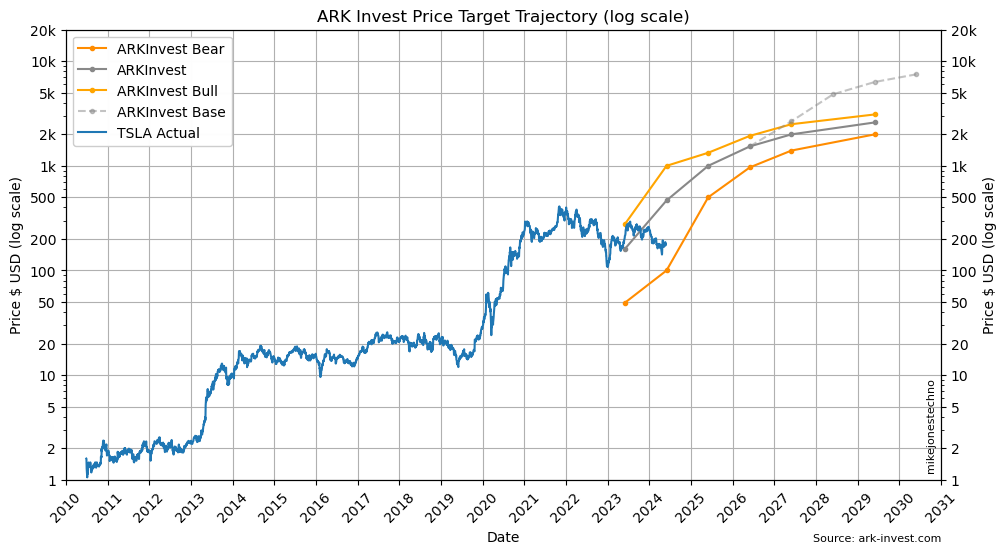

In [11]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = 'ARK Invest Price Target Trajectory (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
log_chart_params['y_secondary'] = True
log_chart_params['human_format'] = True
log_chart = LogChart(**log_chart_params)
plt_log, colors = log_chart.base_chart(df_tsla)

plt_log = plot_rolling_forecast(plt_log, df_targets, 'ARKInvest')
plt_log = plot_forecast(plt_log, df_targets, 'ARKInvest')

plt_log.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

legend = plt_log.legend(loc='best')
legend.get_frame().set_alpha(0.98)
plt_log.show()

## Solving The Money Problem

A few retail investors have also published a long term price target trajectory. There are many factors that are difficult to forecast, and other factors that are not yet known. Investors should also consider a range of possible potential outcomes rather than attempting to forecast a single absolute value.

Before ARK Invest's 2026 price targets were published, Steven Mark Ryan published a 10 year price target trajectory on [Solving the Money Problem](https://www.youtube.com/watch?v=W0OKbs_N51A) on 21 March 2022. SMR had modelled a bear case with 5% probability, a base case with 60% probability, a bull case with 33% probability and a ridiculous hyper-bull case with only 2% probability. These models are regularly updated and available on a small subscriber fee. 

The SMR 'weighted average price target' is plotted below. These are not absolute values, the range of possible price targets are only available to his subscribers.

> ⚠ Disclaimer: _Not financial advice._ Price targets are a FORECAST of what a stock SHOULD be worth, not an estimate of what institutional investors believe or what the sotck WILL actually be worth, and each forecast is based on a range of assumptions used in that model. All content is for educational purposes only. The 'cone of uncertainty' beceomes increasingly wider the further the forecasts project into the future.

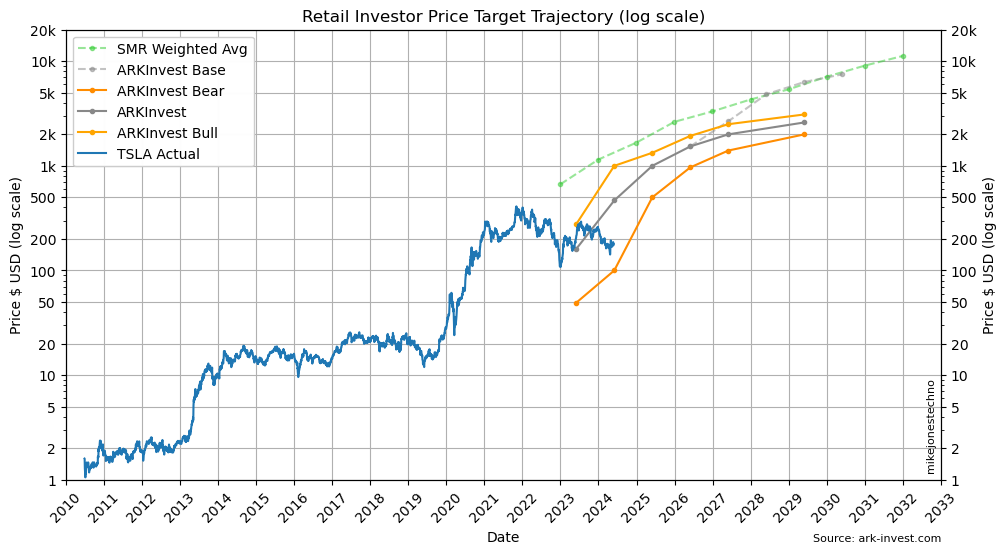

In [12]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = 'Retail Investor Price Target Trajectory (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
#log_chart_params['y_ticks'] = [10, 20, 40, 60, 80, 100, 150, 200, 300, 400, 600, 800, 1000, 2000, 3000, 4000, 6000, 8000, 10000, 15000, 20000]
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
log_chart_params['y_secondary'] = True
log_chart_params['human_format'] = True
#log_chart_params['start_year'] = 2019
log_chart_params['end_year'] = 2033

log_chart = LogChart(**log_chart_params)
plt_log, colors = log_chart.base_chart(df_tsla)

plt_log = plot_forecast(plt_log, df_targets, 'SMR', 'SMR Weighted Avg')
#plt_log = plot_forecast(plt_log, df_targets, 'InvestA')
#plt_log = plot_forecast(plt_log, df_targets, 'RandyKirk')

plt_log = plot_forecast(plt_log, df_targets, 'ARKInvest')
plt_log = plot_rolling_forecast(plt_log, df_targets, 'ARKInvest')

plt_log.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

legend = plt_log.legend(loc='best')
legend.get_frame().set_alpha(0.98)

plt_log.show()

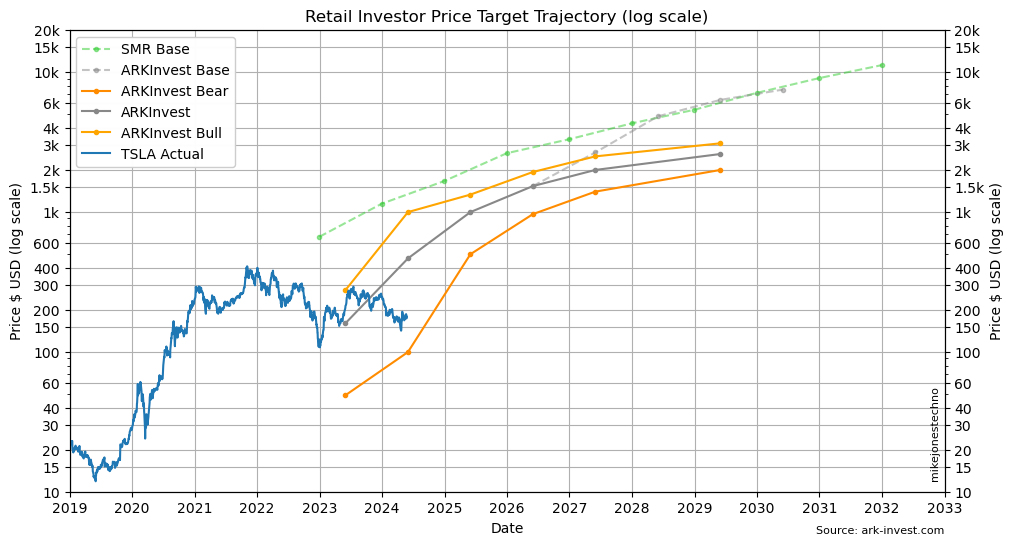

In [13]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = 'Retail Investor Price Target Trajectory (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [10, 15, 20, 30, 40, 60, 100, 150, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 4000, 6000, 10000, 15000, 20000]
#log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
log_chart_params['y_secondary'] = True
log_chart_params['human_format'] = True
log_chart_params['start_year'] = 2019
log_chart_params['end_year'] = 2033

log_chart = LogChart(**log_chart_params)
plt_log, colors = log_chart.base_chart(df_tsla)

plt_log = plot_forecast(plt_log, df_targets, 'SMR')
#plt_log = plot_forecast(plt_log, df_targets, 'InvestA')
#plt_log = plot_forecast(plt_log, df_targets, 'RandyKirk')

plt_log = plot_forecast(plt_log, df_targets, 'ARKInvest')
plt_log = plot_rolling_forecast(plt_log, df_targets, 'ARKInvest')

plt_log.plot(df_tsla.index, df_tsla[data_column], color=colors[0]['color'], label='TSLA Actual')

legend = plt_log.legend(loc='best')
legend.get_frame().set_alpha(0.98)

plt_log.show()